Variables

### Functions and Packages

In [4]:
import numpy as np

In [5]:
def bids2rewards(bids, valuations, design):
    # Input: vector of bids and valuations
    # Output: vector of auction rewards
    winning_bid_val = np.max(bids)
    winning_bid_idx = np.where(bids==winning_bid_val,1,0)
    no_of_winners = np.sum(winning_bid_idx)
    second_highest_bid_val = np.partition(bids.flatten(), -2)[-2]
    winners_payment = design * winning_bid_val + (1-design) * second_highest_bid_val
    print(no_of_winners, valuations.shape, winners_payment, winning_bid_idx.shape)
    expected_rewards = (1/no_of_winners) * (valuations - winners_payment) * winning_bid_idx 
    return expected_rewards

In [6]:
def initialize_qtable(N, num_actions, feedback):
    # Input: number of bidders, action space size, feedback
    # Output: master Q table
    if feedback == 1:
            Q = np.random.uniform(0,1,(N, num_actions,num_actions))
    else:
        Q = np.random.uniform(0,1,(N, num_actions))
    return Q

In [7]:
def exploratory_strategy(Q, N, egreedy, num_actions,past_win,winning_bid,eps,beta):
    # Input: Master Q table, agent index, past winning action
    # Output: actions taken by all agents
    actions = np.ones(N,dtype=int)
    for agent_idx in range(N):
        if egreedy == 0:
            if past_win == 1:
                if np.random.uniform()>eps:
                    actions[agent_idx] = np.argmax(Q[agent_idx,winning_bid])
                else:
                    actions[agent_idx] = np.random.choice(range(num_actions))
            else:
                if np.random.uniform()>eps:
                    actions[agent_idx] = np.argmax(Q[agent_idx])
                else:
                    actions[agent_idx] = np.random.choice(range(num_actions))
        else: 
            if past_win == 1:
                max_Q = np.max(Q[agent_idx,winning_bid])
                logits = (Q[agent_idx,winning_bid] - max_Q) / beta
                exp_logits = np.exp(logits)
                probs = exp_logits / np.sum(exp_logits)
                actions[agent_idx] = np.random.choice(range(len(probs)), p=probs)
            else:
                max_Q = np.max(Q[agent_idx])
                logits = (Q[agent_idx] - max_Q) / beta
                exp_logits = np.exp(logits)
                probs = exp_logits / np.sum(exp_logits)
                actions[agent_idx] = np.random.choice(range(len(probs)), p=probs)    
    return actions

In [8]:
def bids2rewards(bids, valuations, design):
    # Input: vector of bids and valuations
    # Output: vector of auction rewards
    winning_bid_val = np.max(bids)
    winning_bid_idx = np.where(bids==winning_bid_val,1,0)
    no_of_winners = np.sum(winning_bid_idx)
    second_highest_bid_val = np.partition(bids.flatten(), -2)[-2]
    winners_payment = design * winning_bid_val + (1-design) * second_highest_bid_val
    expected_rewards = (1/no_of_winners) * (valuations - winners_payment) * winning_bid_idx 
    return expected_rewards

def actions2rewards(actions,valuations,design,num_actions,common_valuation):
    bids = actions*common_valuation/(num_actions-1)
    rewards = bids2rewards(bids, valuations, design)
    return rewards 

def counterfactual_reward(agent_idx,actions,valuations,design,num_actions,common_valuation):
    # Input: agent_idx, vector of actions taken
    # Output: counterfactual profits for every action possible
    cf_rewards = np.zeros(num_actions)
    for agent_action in range(num_actions-1):
        actions[agent_idx] = agent_action
        cf_rewards[agent_action] = actions2rewards(actions,valuations,design,num_actions,common_valuation)[agent_idx]
    return np.array(cf_rewards)

In [9]:
def update_qvalues(rewards, actions, Q, feedback, asynchronous, winning_bid, alpha, gamma, N,valuations,design,num_actions,common_valuation):
    for agent_idx in range(N-1):
        action = actions[agent_idx]
        reward = rewards[agent_idx]
        if asynchronous == 1:
            if feedback == 1:
                Q[agent_idx,winning_bid,action] =  (1-alpha)*Q[agent_idx,winning_bid,action] + alpha * (reward + gamma * np.max(Q[agent_idx,winning_bid]))
            else:
                Q[agent_idx,action] =  (1-alpha)*Q[agent_idx,action] + alpha * (reward + gamma * np.max(Q[agent_idx]))
        else: 
            reward_vec = counterfactual_reward(agent_idx,actions,valuations,design,num_actions,common_valuation)
            if feedback == 1:
                Q[agent_idx,winning_bid,:] =  (1-alpha)*Q[agent_idx,winning_bid,:] + alpha * (reward_vec + gamma * np.max(Q[agent_idx,winning_bid]))
            else:
                Q[agent_idx] =  (1-alpha)*Q[agent_idx] + alpha * (reward_vec + gamma * np.max(Q[agent_idx]))
    return Q

In [39]:
def experiment(N,alpha,gamma,egreedy,asynchronous, design,feedback,num_actions,verbose=1):
    Q = initialize_qtable(N, num_actions,feedback)
    common_valuation = 1
    valuations = np.ones(N)*common_valuation
    action2bid = np.linspace(0,common_valuation,num_actions)
    initial_eps = 1.0
    eps_decay = 0.99999
    min_eps = 0.001
    eps = initial_eps
    initial_beta = 1.0
    beta_decay = 0.999999
    min_beta = 0.001
    beta = initial_beta
    winning_bid_history = []
    num_episodes = 1000000
    winning_action = 0
    
    # training loop
    for episode in range(num_episodes):
        
        # act from exploratory strategy
        actions = exploratory_strategy(Q, N, egreedy, num_actions,feedback,winning_action,eps,beta) 

        # collect rewards
        rewards = actions2rewards(actions,valuations,design,num_actions,common_valuation)
        
        # update Q-values
        Q = update_qvalues(rewards, actions, Q, feedback, asynchronous, winning_action, alpha, gamma,  N,valuations,design,num_actions,common_valuation)
        
        # update exploration params
        eps = max(min_eps, eps * eps_decay)
        beta = max(min_beta, beta * beta_decay)

        # winning bid and action
        bids = actions*common_valuation/(num_actions-1)
        winning_bid = np.max(bids)
        winning_action = np.max(actions)

        # store history
        winning_bid_history.append(winning_bid)
        
        if (verbose==1) & (episode%10000==0) & (episode>0):
            print(episode,eps,beta,np.mean(winning_bid_history[-1000:]),np.std(winning_bid_history[-1000:]))
            
        if (episode%10000==0) & (episode>0) & (np.std(winning_bid_history[-10000:])<0.0001):
            break

    Y = np.mean(winning_bid_history[-1000:])
    return (Y,episode,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions)

### Test Case 

In [41]:
params = {'N': 16, 'alpha': 0.1, 'gamma': 0.95, 'egreedy': 0, 'design': 1, 
          'asynchronous': 1, 'feedback': 1, 'num_actions': 6}
experiment(**params)

10000 0.9048279172450976 0.9900488387488005 0.9886 0.04636852380656515


KeyboardInterrupt: 

### Random Sampling

In [19]:
import random

parameters = {'N':[2,6],
              'alpha':[0.01,0.1],
              'gamma':[0.0,0.99],
              'egreedy':[0,1],
              'design':[0,1],
              'asynchronous':[0,1],
              'feedback':[0,1],
              'num_actions':[6,16]
             }

K = 200  # Number of times to sample
data = []
for _ in range(K):
    sampled_params = {}
    for key, value in parameters.items():
        if isinstance(value, list):
            sampled_params[key] = random.choice(value)
        else:
            sampled_params[key] = value
    
    print(_,"Sampled Parameters:", sampled_params)
    data.append(experiment(**sampled_params))
    print("-" * 20)

0 Sampled Parameters: {'N': 2, 'alpha': 0.1, 'gamma': 0.0, 'egreedy': 0, 'design': 0, 'asynchronous': 1, 'feedback': 1, 'num_actions': 6}
[1. 1.]
0 0.99999 9.9999
10000 0.9048279172450976 9.048279172451016
20000 0.81872174704358 8.187217470435849


KeyboardInterrupt: 

In [100]:
import random

parameters = {'N':[2,4,6],
              'alpha':[0.01,0.05,0.1],
              'gamma':[0.0,0.5,0.9],
              'egreedy':[0,1],
              'design':[0,0.5,1],
              'asynchronous':[0,1],
              'feedback':[0,1],
              'num_actions':[6,11,16]
             }

K = 200  # Number of times to sample
data = []
for _ in range(K):
    sampled_params = {}
    for key, value in parameters.items():
        if isinstance(value, list):
            sampled_params[key] = random.choice(value)
        else:
            sampled_params[key] = value
    
    print(_,"Sampled Parameters:", sampled_params)
    data.append(experiment(**sampled_params))
    print("-" * 20)

0 Sampled Parameters: {'N': 6, 'alpha': 0.1, 'gamma': 0.9, 'egreedy': 1, 'design': 1, 'asynchronous': 0, 'feedback': 0, 'num_actions': 11}
[1. 1. 1. 1. 1. 1.]
0 0.99999 9.9999
10000 0.9048279172450976 9.048279172451016
20000 0.81872174704358 8.187217470435849
30000 0.7408097012777304 7.408097012777324
40000 0.6703120022021174 6.7031200220211975
50000 0.6065230780877152 6.065230780877165
60000 0.5488045015522138 5.48804501552211
70000 0.49657859990022574 4.965785999002237
80000 0.44932267352294725 4.493226735229405
90000 0.4065637644924138 4.065637644924142
100000 0.36787392299223054 3.6787392299222628
110000 0.3328659242090879 3.328659242090818
120000 0.3011893928179029 3.0118939281789756
130000 0.27252729627270095 2.7252729627269856
140000 0.24659277180658673 2.4659277180658434
150000 0.22312625538400394 2.2312625538400157
160000 0.20189288387064636 2.0189288387064313
170000 0.18268014442072797 1.826801444207254
180000 0.16529574755571724 1.6529574755571521
190000 0.14956570264733773 

840000 0.001 0.0022485563131639545
850000 0.001 0.002034576871417172
860000 0.001 0.0018409603626430991
870000 0.001 0.0016657689883510243
880000 0.001 0.0015072493568347022
890000 0.001 0.001363814934463107
900000 0.001 0.001234030166959688
910000 0.001 0.0011165961117488785
920000 0.001 0.0010103374375720914
930000 0.001 0.001
940000 0.001 0.001
950000 0.001 0.001
960000 0.001 0.001
970000 0.001 0.001
980000 0.001 0.001
990000 0.001 0.001
--------------------
2 Sampled Parameters: {'N': 6, 'alpha': 0.01, 'gamma': 0.5, 'egreedy': 0, 'design': 1, 'asynchronous': 1, 'feedback': 0, 'num_actions': 16}
[1. 1. 1. 1. 1. 1.]
0 0.99999 9.9999
10000 0.9048279172450976 9.048279172451016
20000 0.81872174704358 8.187217470435849
30000 0.7408097012777304 7.408097012777324
40000 0.6703120022021174 6.7031200220211975
50000 0.6065230780877152 6.065230780877165
60000 0.5488045015522138 5.48804501552211
70000 0.49657859990022574 4.965785999002237
80000 0.44932267352294725 4.493226735229405
90000 0.40656

700000 0.001 0.009118409315600122
710000 0.001 0.008250673816360903
720000 0.001 0.00746551466027314
730000 0.001 0.006755073631954069
740000 0.001 0.006112240327641583
750000 0.001 0.005530580991171358
760000 0.001 0.005004274122138123
770000 0.001 0.004528052211779923
780000 0.001 0.00409714902345217
790000 0.001 0.003707251890051969
800000 0.001 0.003354458550964197
810000 0.001 0.003035238096534916
820000 0.001 0.002746395629186968
830000 0.001 0.0024850402874911958
840000 0.001 0.0022485563131639545
850000 0.001 0.002034576871417172
860000 0.001 0.0018409603626430991
870000 0.001 0.0016657689883510243
880000 0.001 0.0015072493568347022
890000 0.001 0.001363814934463107
900000 0.001 0.001234030166959688
910000 0.001 0.0011165961117488785
920000 0.001 0.0010103374375720914
930000 0.001 0.001
940000 0.001 0.001
950000 0.001 0.001
960000 0.001 0.001
970000 0.001 0.001
980000 0.001 0.001
990000 0.001 0.001
--------------------
4 Sampled Parameters: {'N': 6, 'alpha': 0.1, 'gamma': 0.5, 

610000 0.002242776884676774 0.022427768846766696
620000 0.0020293474308818757 0.02029347430881742
630000 0.0018362285715372718 0.01836228571537135
640000 0.0016614874888449087 0.016614874888447834
650000 0.001503375297813311 0.015033752978131996
660000 0.0013603095426535782 0.013603095426534774
670000 0.0012308583588714734 0.012308583588713777
680000 0.001113726142542824 0.011137261425427408
690000 0.001007740583344288 0.01007740583344201
700000 0.001 0.009118409315600122
710000 0.001 0.008250673816360903
720000 0.001 0.00746551466027314
730000 0.001 0.006755073631954069
740000 0.001 0.006112240327641583
750000 0.001 0.005530580991171358
760000 0.001 0.005004274122138123
770000 0.001 0.004528052211779923
780000 0.001 0.00409714902345217
790000 0.001 0.003707251890051969
800000 0.001 0.003354458550964197
810000 0.001 0.003035238096534916
820000 0.001 0.002746395629186968
830000 0.001 0.0024850402874911958
840000 0.001 0.0022485563131639545
850000 0.001 0.002034576871417172
860000 0.001 

520000 0.005516365826915102 0.055163658269147535
530000 0.004991411716046814 0.04991411716046508
540000 0.004516413831281774 0.045164138312814746
550000 0.004086618186557535 0.040866181865572566
560000 0.003697723199550813 0.03697723199550581
570000 0.0033458366395648577 0.03345836639564659
580000 0.0030274366723865463 0.03027436672386382
590000 0.0027393366122330774 0.027393366122329642
600000 0.0024786530280104194 0.02478653028010304
610000 0.002242776884676774 0.022427768846766696
620000 0.0020293474308818757 0.02029347430881742
630000 0.0018362285715372718 0.01836228571537135
640000 0.0016614874888449087 0.016614874888447834
650000 0.001503375297813311 0.015033752978131996
660000 0.0013603095426535782 0.013603095426534774
670000 0.0012308583588714734 0.012308583588713777
680000 0.001113726142542824 0.011137261425427408
690000 0.001007740583344288 0.01007740583344201
700000 0.001 0.009118409315600122
710000 0.001 0.008250673816360903
720000 0.001 0.00746551466027314
730000 0.001 0.0

430000 0.013568131606966374 0.13568131606965958
440000 0.01227694703230919 0.12276947032308666
450000 0.011108635499727796 0.11108635499727267
460000 0.010051504037694083 0.1005150403769364
470000 0.009094972413331634 0.09094972413331207
480000 0.008229467240828932 0.08229467240828577
490000 0.007446326166817745 0.07446326166817371
500000 0.006737711173761154 0.0673771117376081
510000 0.00609653013365474 0.060965301336543584
520000 0.005516365826915102 0.055163658269147535
530000 0.004991411716046814 0.04991411716046508
540000 0.004516413831281774 0.045164138312814746
550000 0.004086618186557535 0.040866181865572566
560000 0.003697723199550813 0.03697723199550581
570000 0.0033458366395648577 0.03345836639564659
580000 0.0030274366723865463 0.03027436672386382
590000 0.0027393366122330774 0.027393366122329642
600000 0.0024786530280104194 0.02478653028010304
610000 0.002242776884676774 0.022427768846766696
620000 0.0020293474308818757 0.02029347430881742
630000 0.0018362285715372718 0.01

330000 0.036882190004907146 0.3688219000490624
340000 0.03337236888926707 0.3337236888926674
350000 0.030196553001141154 0.3019655300114064
360000 0.02732295738957781 0.27322957389577407
370000 0.024722821856007 0.2472282185600664
380000 0.022370123109623722 0.22370123109623283
390000 0.020241314314940705 0.20241314314940195
400000 0.018315089424785415 0.1831508942478506
410000 0.016572169940085958 0.16572169940085416
420000 0.01499511196223951 0.14995111962239083
430000 0.013568131606966374 0.13568131606965958
440000 0.01227694703230919 0.12276947032308666
450000 0.011108635499727796 0.11108635499727267
460000 0.010051504037694083 0.1005150403769364
470000 0.009094972413331634 0.09094972413331207
480000 0.008229467240828932 0.08229467240828577
490000 0.007446326166817745 0.07446326166817371
500000 0.006737711173761154 0.0673771117376081
510000 0.00609653013365474 0.060965301336543584
520000 0.005516365826915102 0.055163658269147535
530000 0.004991411716046814 0.04991411716046508
54000

230000 0.10025668816918634 1.0025668816918467
240000 0.09071595750559149 0.9071595750559026
250000 0.08208315172219692 0.8208315172219559
260000 0.07427186993240854 0.7427186993240702
270000 0.06720393342017499 0.6720393342017351
280000 0.06080860319328729 0.6080860319328609
290000 0.05502187199668613 0.5502187199668483
300000 0.0497858236999252 0.4978582369992428
310000 0.04504805364727133 0.4504805364727043
320000 0.04076114416904805 0.40761144169046976
330000 0.036882190004907146 0.3688219000490624
340000 0.03337236888926707 0.3337236888926674
350000 0.030196553001141154 0.3019655300114064
360000 0.02732295738957781 0.27322957389577407
370000 0.024722821856007 0.2472282185600664
380000 0.022370123109623722 0.22370123109623283
390000 0.020241314314940705 0.20241314314940195
400000 0.018315089424785415 0.1831508942478506
410000 0.016572169940085958 0.16572169940085416
420000 0.01499511196223951 0.14995111962239083
430000 0.013568131606966374 0.13568131606965958
440000 0.01227694703230

130000 0.27252729627270095 2.7252729627269856
140000 0.24659277180658673 2.4659277180658434
150000 0.22312625538400394 2.2312625538400157
160000 0.20189288387064636 2.0189288387064313
170000 0.18268014442072797 1.826801444207254
180000 0.16529574755571724 1.6529574755571521
190000 0.14956570264733773 1.495657026473365
200000 0.13533257654345696 1.35332576543454
210000 0.12245391790840911 1.2245391790840638
220000 0.11080083150788375 1.108008315078824
230000 0.10025668816918634 1.0025668816918467
240000 0.09071595750559149 0.9071595750559026
250000 0.08208315172219692 0.8208315172219559
260000 0.07427186993240854 0.7427186993240702
270000 0.06720393342017499 0.6720393342017351
280000 0.06080860319328729 0.6080860319328609
290000 0.05502187199668613 0.5502187199668483
300000 0.0497858236999252 0.4978582369992428
310000 0.04504805364727133 0.4504805364727043
320000 0.04076114416904805 0.40761144169046976
330000 0.036882190004907146 0.3688219000490624
340000 0.03337236888926707 0.333723688

20000 0.81872174704358 8.187217470435849
30000 0.7408097012777304 7.408097012777324
40000 0.6703120022021174 6.7031200220211975
50000 0.6065230780877152 6.065230780877165
60000 0.5488045015522138 5.48804501552211
70000 0.49657859990022574 4.965785999002237
80000 0.44932267352294725 4.493226735229405
90000 0.4065637644924138 4.065637644924142
100000 0.36787392299223054 3.6787392299222628
110000 0.3328659242090879 3.328659242090818
120000 0.3011893928179029 3.0118939281789756
130000 0.27252729627270095 2.7252729627269856
140000 0.24659277180658673 2.4659277180658434
150000 0.22312625538400394 2.2312625538400157
160000 0.20189288387064636 2.0189288387064313
170000 0.18268014442072797 1.826801444207254
180000 0.16529574755571724 1.6529574755571521
190000 0.14956570264733773 1.495657026473365
200000 0.13533257654345696 1.35332576543454
210000 0.12245391790840911 1.2245391790840638
220000 0.11080083150788375 1.108008315078824
230000 0.10025668816918634 1.0025668816918467
240000 0.09071595750

KeyboardInterrupt: 

In [101]:
import pandas as pd
df = pd.DataFrame(data, columns = ['bid2val','N','alpha','gamma','egreedy','design','asynchronous','feedback','num_actions'])
df.to_pickle('data_exp20.pkl')

In [ ]:
(Y, N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions)

In [70]:
df3.columns = ['bid2val','N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions']

In [1]:
import pandas as pd

df3 = pd.read_pickle('data_main.pkl')

In [2]:
df3.shape,  df3.shape

((374, 10), (374, 10))

In [103]:
df3 = pd.concat([df3,df],axis=0)

In [15]:
df3=df

In [72]:
df3.to_pickle('data_main2.pkl')

<AxesSubplot: >

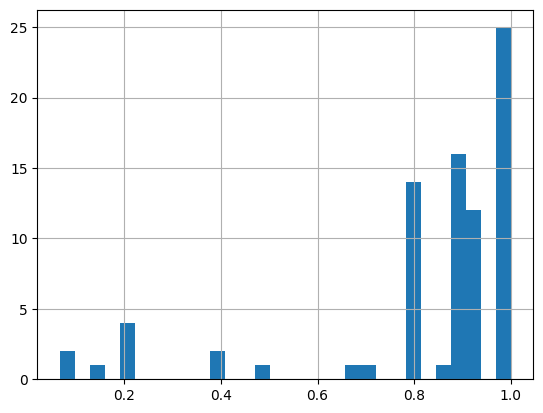

In [104]:
df3.bid2val.hist(bins=30)

<AxesSubplot: >

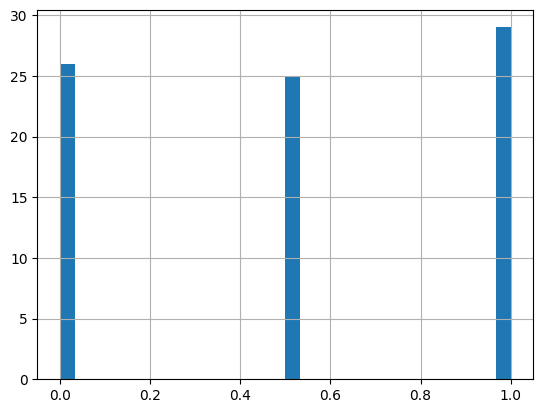

In [105]:
df3.design.hist(bins=30)

<AxesSubplot: >

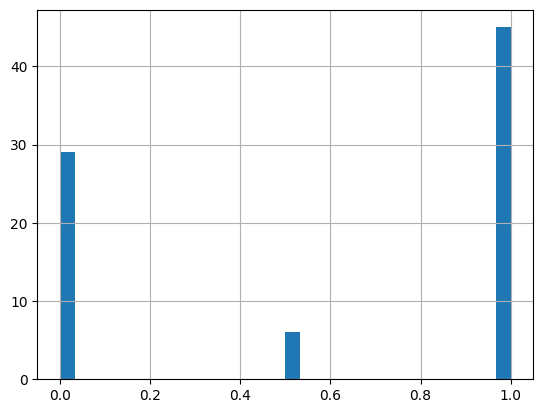

In [106]:
df3.asynchronous.hist(bins=30)

In [75]:
df3.head(20)

,bid2val,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions
0,0.933333,6,0.10,0.0,0,0,0.5,1,16
1,0.800000,6,0.01,0.5,0,0,1.0,1,6
2,0.900000,2,0.05,0.9,1,0,0.0,1,11
3,1.000000,6,0.05,0.5,1,1,0.5,0,11
4,0.933333,6,0.01,0.9,1,0,0.0,1,16
5,0.666667,2,0.10,0.5,0,1,0.5,1,16
6,0.933333,2,0.05,0.9,1,0,0.5,1,16
7,0.400000,2,0.01,0.9,1,1,0.5,0,6
8,1.000000,2,0.05,0.9,1,1,0.0,0,6
9,1.000000,6,0.05,0.9,0,1,0.5,0,16


In [37]:
df3 = df3.drop('counterfactual',axis=1)

In [11]:
df3['counterfactual'] = 0 
df3.loc[(df3.feedback == 1) & (df3.asynchronous == 1), 'counterfactual'] = 1

### Experimental Results

In [3]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.ols('bid2val ~ N + alpha + gamma + egreedy + design + asynchronous + feedback + num_actions', data =df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                bid2val   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     18.91
Date:                Thu, 25 May 2023   Prob (F-statistic):           9.01e-24
Time:                        08:30:05   Log-Likelihood:                 155.42
No. Observations:                 374   AIC:                            -292.8
Df Residuals:                     365   BIC:                            -257.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8116      0.036     22.565   

In [78]:
y = df3['bid2val']
X = df3.drop(['bid2val'],axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Assuming X contains the features and y contains the target variable

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100,max_depth=3)

# Define the number of folds for cross-validation
k_folds = 5

# Perform cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)
cross_val_scores = cross_val_score(rf_regressor, X, y, cv=kf, scoring='r2')

# Print the performance metrics
print("Cross-validation scores:", cross_val_scores)
print("Average R-squared:", cross_val_scores.mean())

Cross-validation scores: [-0.23684646  0.23611333  0.6169447   0.12509834  0.26915933]
Average R-squared: 0.20209384749481457


In [79]:
rf_regressor.fit(X, y)
# Get feature importances
importances = rf_regressor.feature_importances_

# Get the indices that would sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature importance ranking
print("Feature Importance Ranking:")
for i, idx in enumerate(indices):
    print(f"{i + 1}. Feature {idx + 1}: {importances[idx]}")

Feature Importance Ranking:
1. Feature 1: 0.3136089764896186
2. Feature 6: 0.27748339780756087
3. Feature 8: 0.13588566958249035
4. Feature 5: 0.11715348643953591
5. Feature 3: 0.08033033023234909
6. Feature 2: 0.039195980223888774
7. Feature 7: 0.02205811351302632
8. Feature 4: 0.014284045711530202


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance

# Assuming X contains the features and y contains the target variable

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100)

# Fit the model to the data
rf_regressor.fit(X, y)

# Calculate feature importance using permutation importance
perm_importance = PermutationImportance(rf_regressor).fit(X, y)

# Display feature importance
eli5.show_weights(perm_importance)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

X = df3.drop(['bid2val','design'],axis=1)
T  = df3['design']
# Concatenate the treatment indicator and covariates
data = pd.concat([T, X], axis=1)

# Fit a logistic regression model to estimate propensity scores
logit_model = sm.Logit(T, X)
propensity_scores = logit_model.fit().predict(X)

# Estimate the treatment effect using propensity scores
treated_outcomes = y[T == 1]
untreated_outcomes = y[T == 0]

ATE = np.mean(treated_outcomes) - np.mean(untreated_outcomes)

# Print the estimated treatment effect
print("Average Treatment Effect (ATE):", ATE)

In [82]:
from econml.dml import LinearDML
est = LinearDML()
est.fit(y, T, X=X).summary()

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
N,0.033,0.036,0.915,0.36,-0.038,0.104
alpha,-1.994,2.279,-0.875,0.381,-6.46,2.472
gamma,-0.153,0.229,-0.669,0.504,-0.601,0.295
egreedy,0.139,0.127,1.096,0.273,-0.109,0.387
asynchronous,-0.094,0.143,-0.66,0.509,-0.374,0.185
feedback,-0.001,0.131,-0.008,0.993,-0.257,0.255
num_actions,-0.031,0.019,-1.586,0.113,-0.068,0.007
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.229,0.198,1.157,0.247,-0.159,0.618


In [83]:
df3.groupby('N').mean()

,bid2val,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions
N,,,,,,,,
2,0.670238,0.053214,0.542857,0.642857,0.714286,0.535714,0.392857,11.000000
4,0.897778,0.056000,0.493333,0.333333,0.666667,0.566667,0.466667,10.666667
6,0.928070,0.048947,0.421053,0.578947,0.473684,0.473684,0.526316,10.210526


In [84]:
df3.groupby('alpha').mean()

,bid2val,N,gamma,egreedy,asynchronous,design,feedback,num_actions
alpha,,,,,,,,
0.01,0.780952,3.904762,0.504762,0.428571,0.666667,0.571429,0.428571,11.000000
0.05,0.795238,3.523810,0.485714,0.714286,0.476190,0.547619,0.380952,10.285714
0.10,0.838333,3.700000,0.490000,0.500000,0.750000,0.450000,0.550000,10.750000


In [86]:
df3.groupby('gamma').mean()

,bid2val,N,alpha,egreedy,asynchronous,design,feedback,num_actions
gamma,,,,,,,,
0.0,0.803333,3.900000,0.051000,0.600000,0.600000,0.600000,0.600000,11.500000
0.5,0.855556,4.000000,0.058333,0.555556,0.444444,0.416667,0.388889,9.888889
0.9,0.766667,3.333333,0.049583,0.500000,0.791667,0.541667,0.375000,10.583333


In [87]:
df3.groupby('egreedy').mean()

,bid2val,N,alpha,gamma,asynchronous,design,feedback,num_actions
egreedy,,,,,,,,
0,0.816667,3.857143,0.050714,0.528571,0.642857,0.464286,0.428571,10.464286
1,0.794118,3.588235,0.054118,0.464706,0.617647,0.573529,0.470588,10.852941


In [99]:
df3.groupby('design').mean()

,bid2val,N,alpha,gamma,egreedy,asynchronous,feedback,num_actions
design,,,,,,,,
0.0,0.933333,3.882353,0.064118,0.447059,0.470588,0.470588,0.470588,9.529412
0.5,0.832000,3.680000,0.046000,0.604000,0.520000,0.720000,0.520000,10.400000
1.0,0.660000,3.600000,0.051000,0.395000,0.650000,0.650000,0.350000,12.000000


In [89]:
df3.groupby('asynchronous').mean()

,bid2val,N,alpha,gamma,egreedy,design,feedback,num_actions
asynchronous,,,,,,,,
0,0.885507,4.173913,0.048696,0.413043,0.565217,0.456522,0.565217,10.347826
1,0.756410,3.435897,0.054872,0.541026,0.538462,0.564103,0.384615,10.871795


In [90]:
df3.groupby('feedback').mean()

,bid2val,N,alpha,gamma,egreedy,asynchronous,design,num_actions
feedback,,,,,,,,
0,0.764706,3.529412,0.049118,0.558824,0.529412,0.705882,0.558824,10.558824
1,0.852381,3.928571,0.056786,0.414286,0.571429,0.535714,0.482143,10.821429


In [91]:
df3.groupby('num_actions').mean()

,bid2val,N,alpha,gamma,egreedy,asynchronous,design,feedback
num_actions,,,,,,,,
6,0.818182,4.090909,0.053182,0.568182,0.545455,0.636364,0.431818,0.409091
11,0.872727,3.272727,0.053182,0.427273,0.500000,0.545455,0.500000,0.500000
16,0.703704,3.777778,0.051111,0.483333,0.611111,0.722222,0.666667,0.444444


<AxesSubplot: xlabel='asynchronous', ylabel='bid2val'>

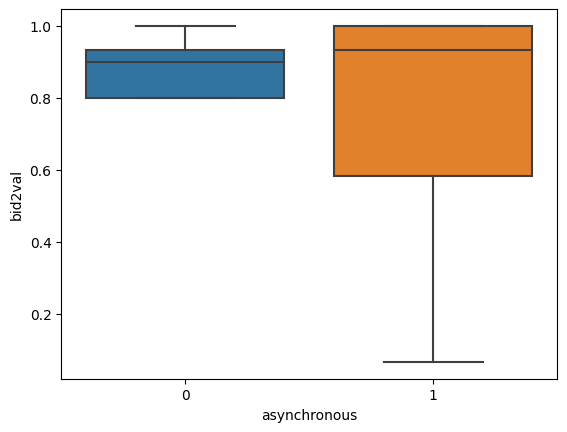

In [93]:
import seaborn as sns
sns.boxplot(data=df3, x="asynchronous", y="bid2val")

<AxesSubplot: xlabel='gamma', ylabel='bid2val'>

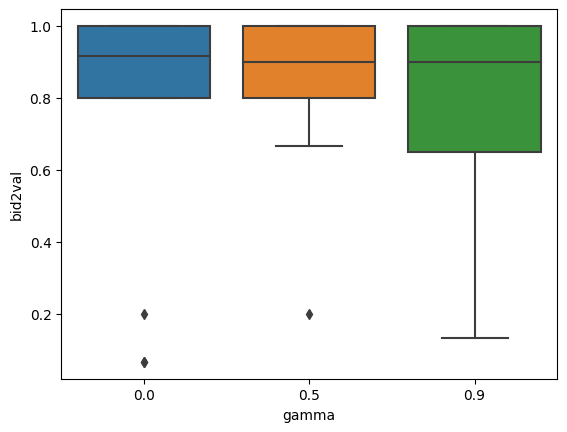

In [98]:
import seaborn as sns
sns.boxplot(data=df3, x="gamma", y="bid2val")

<AxesSubplot: xlabel='alpha', ylabel='bid2val'>

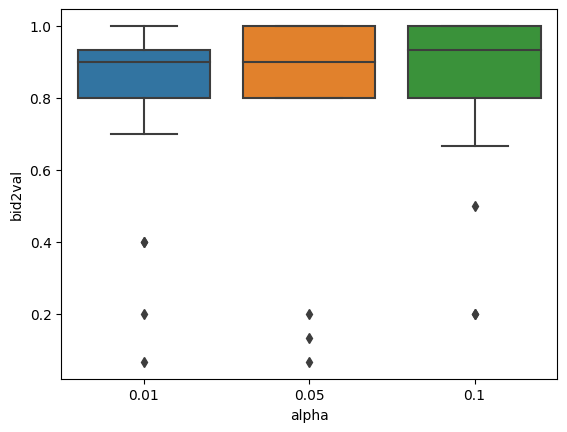

In [97]:
import seaborn as sns
sns.boxplot(data=df3, x="alpha", y="bid2val")